In [30]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from pathlib import Path
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from models.model import TrumpPredictorNN
from sklearn.metrics import confusion_matrix



In [31]:
path_to_data = Path('jass_data')

In [32]:
data = pd.read_csv(path_to_data / 'filtered_data.csv', low_memory=False)

In [33]:
data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,S_J9A,S_J9_plus_card_and_2_other_aces,C_J9,C_AKQ,C_678,C_J_and_4_more,C_9A_and_3_more,C_J9A,C_J9_plus_card_and_2_other_aces,any_specified_feature_true
0,False,True,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,True
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [34]:
feature_columns = data.drop(columns=['trump'])

In [35]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(feature_columns, data['trump'], test_size=0.2, stratify=data['trump'], random_state=42
)


print("X_train shape:", X_train.shape)
print("y_train distribution:\n", y_train.value_counts())

X_train shape: (41193, 66)
y_train distribution:
 trump
UNE_UFE     9404
OBE_ABE     7538
SPADES      7080
CLUBS       6924
HEARTS      5138
DIAMONDS    5109
Name: count, dtype: int64


In [36]:
labels = ['DIAMONDS', 'HEARTS', 'SPADES', 'CLUBS', 'OBE_ABE', 'UNE_UFE']


In [37]:
# Encode the 'trump' target variable
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)    

# Convert encoded targets to tensors
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)


# Define Dataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [38]:
# Initialize model, loss function, and optimizer with updated input_size

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

input_size = X_train.shape[1]  # Confirm this includes all features (66 in total)
output_size = len(set(y_train))  # Number of unique classes in 'trump'
model = TrumpPredictorNN(input_size, output_size)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [39]:
def evaluate_model(model, test_loader):
    model.eval()
    total_loss = 0  # Initialize total loss for validation
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            # Accumulate the loss
            total_loss += loss.item()
    # Calculate average validation loss
    average_loss = total_loss / len(test_loader)
    return average_loss

In [40]:
# Training function

training_losses = []
validation_losses = []
num_epochs = 40

# Training function with average loss calculation and validation
def train_model(model, train_loader, test_loader, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0  # Initialize total training loss
        for X_batch, y_batch in train_loader:
            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(X_batch)
            # Compute loss
            loss = criterion(outputs, y_batch)
            # Backward pass
            loss.backward()
            # Update weights
            optimizer.step()
            # Accumulate training loss
            total_train_loss += loss.item()
        # Calculate average training loss
        average_train_loss = total_train_loss / len(train_loader)
        
        # Compute validation loss
        val_loss = evaluate_model(model, test_loader)
        
        # After calculating average losses
        training_losses.append(average_train_loss)
        validation_losses.append(val_loss)
        
        # Print losses
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_train_loss:.4f}, Validation Loss: {val_loss:.4f}")


In [41]:
# Training the model
train_model(model, train_loader, test_loader, num_epochs)

Epoch 1/40, Training Loss: 1.3694, Validation Loss: 0.7609
Epoch 2/40, Training Loss: 0.8769, Validation Loss: 0.6160
Epoch 3/40, Training Loss: 0.7632, Validation Loss: 0.5886
Epoch 4/40, Training Loss: 0.7032, Validation Loss: 0.5758
Epoch 5/40, Training Loss: 0.6772, Validation Loss: 0.5649
Epoch 6/40, Training Loss: 0.6567, Validation Loss: 0.5602
Epoch 7/40, Training Loss: 0.6426, Validation Loss: 0.5543
Epoch 8/40, Training Loss: 0.6273, Validation Loss: 0.5511
Epoch 9/40, Training Loss: 0.6190, Validation Loss: 0.5491
Epoch 10/40, Training Loss: 0.6091, Validation Loss: 0.5443
Epoch 11/40, Training Loss: 0.6082, Validation Loss: 0.5471
Epoch 12/40, Training Loss: 0.5969, Validation Loss: 0.5429
Epoch 13/40, Training Loss: 0.5955, Validation Loss: 0.5511
Epoch 14/40, Training Loss: 0.5922, Validation Loss: 0.5408
Epoch 15/40, Training Loss: 0.5883, Validation Loss: 0.5407
Epoch 16/40, Training Loss: 0.5842, Validation Loss: 0.5388
Epoch 17/40, Training Loss: 0.5822, Validation Lo

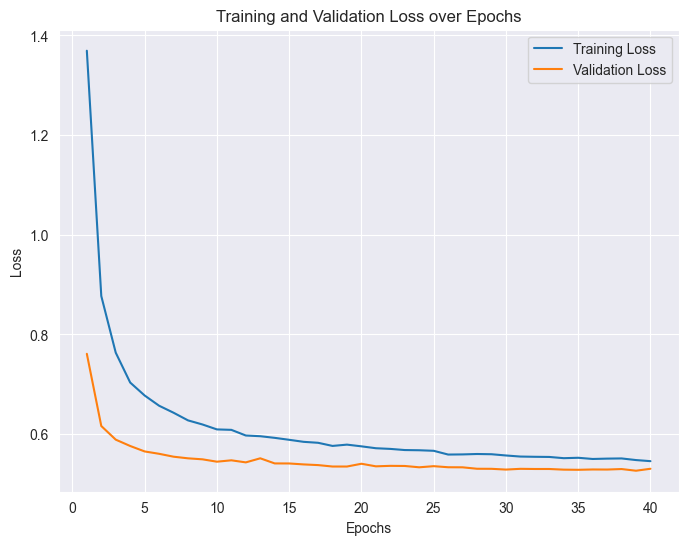

In [42]:
# After training is complete
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [43]:
def predict(model, X):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        _, predictions = torch.max(outputs, 1)
    return predictions


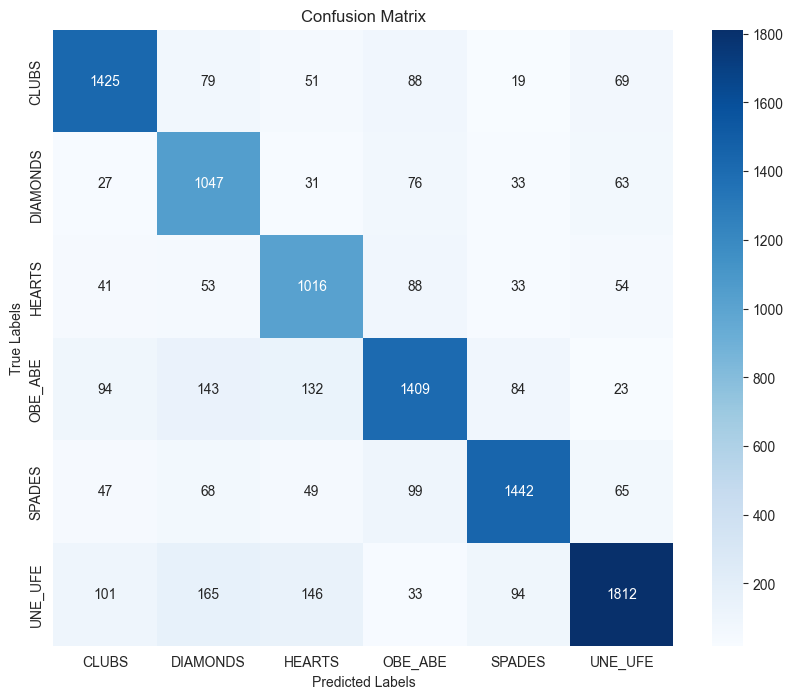

In [44]:
# Ensure the model is in evaluation mode
model.eval()

# Lists to store true labels and predictions
all_targets = []
all_preds = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        all_targets.extend(y_batch.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())


# Compute confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# Use label encoder classes, which now excludes 'PUSH'
labels = label_encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')

plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()


In [45]:
# Save the entire model
torch.save(model, 'models/trump_predictor.pth')

In [46]:
# Save the label encoder
with open('encoder/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)


In [28]:
print(X_train)

           DA     DK     DQ     DJ    D10     D9     D8     D7     D6     HA  \
101697  False  False  False  False  False  False  False  False  False  False   
226689  False  False  False  False  False  False   True  False   True   True   
41818    True   True  False  False  False  False  False  False   True   True   
121525  False   True  False  False   True  False  False  False  False  False   
43035   False  False  False   True  False  False  False  False  False  False   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
227177  False   True  False  False  False  False  False   True  False  False   
11043   False  False  False  False  False  False  False   True   True  False   
34206   False  False  False  False   True  False  False   True  False   True   
212374   True  False  False  False   True   True  False  False  False  False   
105154  False  False  False  False   True  False   True  False  False  False   

        ...  H_9A_and_3_more  H_J9A  H_